### Lista para lembrar

- Fazer um `pip freeze` para os `requirements.txt`

- usar a pasta `manipulated_data` criado no nosso repositório

- precisa baixar as imagens do *dataset* completo para criar a pasta com as imagens que serão usadas para teste

- precisa do arquivo `used_clothes.csv` do nosso repositório

### Importando bibliotecas

In [1]:
# Importing the Keras libraries and packages
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator

import shutil

Using TensorFlow backend.


### Tratamento dos dados

Criando pastas com as imagens a serem usadas para treino e teste

In [2]:
used_clothes_df = pd.read_csv("used_clothes.csv")
used_clothes_list = used_clothes_df.file_name.tolist()

In [3]:
initial_filtered_clothes_df = pd.read_csv("manipulated_data/initial_filtered_clothes.csv")
initial_filtered_clothes_list = initial_filtered_clothes_df.file_name.tolist()

test_clothes_list = []

for img in os.listdir('images'):
    if img not in used_clothes_list and img in initial_filtered_clothes_list:
        test_clothes_list.append(img)

In [4]:
test_dataset = test_clothes_list[:len(used_clothes_list)//2]

In [5]:
os.makedirs("dataset_test", exist_ok=True)

for img in test_dataset:
    caminho_origem = os.path.join("images", img)
    caminho_destino = os.path.join("dataset_test", img)

    if os.path.exists(caminho_origem):
        shutil.copy(caminho_origem, caminho_destino)
    else:
        print(f'Arquivo não encontrado: {img}')

In [6]:
test_dataframe = pd.DataFrame({"file_name": test_dataset})

### Modelo

Criando o modelo

In [32]:
# Criando o classificador
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu')) # por padrão kernel_size é (3, 3)

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2))) # por padrão pool_size é (2, 2)

# Adding a second convolutional layer
classifier.add(Conv2D(32, (3, 3), activation = 'relu')) # por padrão kernel_size é (3, 3)
classifier.add(MaxPooling2D(pool_size = (2, 2))) # por padrão pool_size é (2, 2)

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 6, activation = 'softmax'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [34]:
classifier.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_6 (Dense)              (None, 6)                

### Realizando o fitting

In [ ]:
# Part 2 - Fitting the CNN to the images

train_datagen = ImageDataGenerator(rescale=1. / 255)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('manipulated_data/images',
                                                 target_size=(64, 64),
                                                 batch_size=16,
                                                 class_mode='categorical')

test_set = test_datagen.flow_from_dataframe(dataframe=test_dataframe,
                                            directory='dataset_test',
                                            x_col='file_name',
                                            class_mode=None,
                                            target_size=(64, 64),
                                            batch_size=16,
                                            shuffle=False)

Found 6845 images belonging to 6 classes.
Found 3422 validated image filenames.


In [87]:
classifier.fit(training_set, steps_per_epoch=800, epochs=5)


Epoch 1/5
800/800 [==============================] - 161s 202ms/step - loss: 1.3963 - accuracy: 0.4429
Epoch 2/5
800/800 [==============================] - 163s 204ms/step - loss: 1.2722 - accuracy: 0.5066
Epoch 3/5
800/800 [==============================] - 172s 215ms/step - loss: 1.1620 - accuracy: 0.5474
Epoch 4/5
800/800 [==============================] - 191s 239ms/step - loss: 1.0769 - accuracy: 0.5942
Epoch 5/5
800/800 [==============================] - 192s 240ms/step - loss: 1.0048 - accuracy: 0.6236


In [88]:
predictions = classifier.predict(test_set)

### Salvando o modelo em um arquivo

In [89]:
# Save Model to Disk
# serialize model to JSON
model_json = classifier.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
classifier.save_weights("model.h5")
print("Saved model to disk")
 

Saved model to disk


### Testando o modelo com uma imagem

In [90]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('dataset_test/1256068887f7474a97396d5a09d85943.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
training_set.class_indices

{'animal_print': 0,
 'checkers': 1,
 'floral': 2,
 'pattern': 3,
 'solid': 4,
 'stripes': 5}

In [91]:
result[0]

array([0., 0., 1., 0., 0., 0.], dtype=float32)

In [92]:
index = np.where(result[0] == 1)[0][0]
index

2

In [93]:
list(training_set.class_indices.keys())[list(training_set.class_indices.values()).index(index)]

'floral'

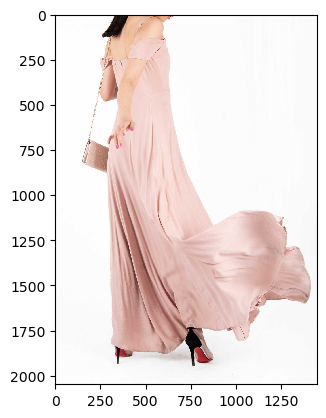

In [94]:
img = cv2.imread('dataset_test/1256068887f7474a97396d5a09d85943.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))